In [24]:
import pandas as pd
from pandas import Series
from pandas import read_csv
from pandas import concat
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
import numpy 
%matplotlib inline

In [25]:
df = read_csv('well_1_clean.csv')
series = Series(data = df['Oil Volume'])

In [26]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [27]:
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [28]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [29]:
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [30]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [31]:
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [32]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [33]:
def fit_lstm(train, test, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    Val_X = test[:, 0]
    Val_X = Val_X.reshape((len(Val_X), 1, 1))
    Val_Y = test[:, 1]
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True,return_sequences=False ))
    #second layer - make sure return_sequences=True to run this layer
    #model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    history = model.fit(X, y, epochs=nb_epoch, validation_data = (Val_X, Val_Y), shuffle = False, batch_size=batch_size)
    return model, history

In [34]:
#Get a dataset of differenced values to make stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [35]:
#returns a dataset with the differenced dataset and a differenced dataset with a lag of 1
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [36]:
#split train and test data
split_fraction = .67
train_size = int(len(supervised_values) * split_fraction)
test_size = len(supervised_values) - train_size
train, test = supervised_values[0 : train_size,:], supervised_values[train_size:len(supervised_values),:]

In [37]:
#Scales the train and the test data
scaler, train_scaled, test_scaled = scale(train, test)

In [38]:
#split train and test for the history parameter
Val_X = test_scaled[:, 0]
Val_X = Val_X.reshape((len(Val_X), 1, 1))
Val_Y = test_scaled[:, 1]

trainX = train_scaled[:, 0]
trainX = trainX.reshape((len(trainX), 1, 1))
trainY = train_scaled[:, 1]


In [39]:
lstm_model, history = fit_lstm(train_scaled, test_scaled, 1, 1000, 4)

Train on 152 samples, validate on 75 samples
Epoch 1/1000
152/152 [==============================] - 0s 3ms/step - loss: 0.0776 - val_loss: 0.0173
Epoch 2/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0173
Epoch 3/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0173
Epoch 4/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0173
Epoch 5/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0173
Epoch 6/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0172
Epoch 7/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0172
Epoch 8/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0172
Epoch 9/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0784 - val_loss: 0.0172
Epoch 10/1000
152/152 [==============

152/152 [==============================] - 0s 2ms/step - loss: 0.0814 - val_loss: 0.0171
Epoch 81/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0815 - val_loss: 0.0171
Epoch 82/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0815 - val_loss: 0.0171
Epoch 83/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0170
Epoch 84/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0170
Epoch 85/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0170
Epoch 86/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0170
Epoch 87/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0170
Epoch 88/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0170
Epoch 89/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0817 - v

152/152 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.0166
Epoch 160/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0166
Epoch 161/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0166
Epoch 162/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0166
Epoch 163/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0166
Epoch 164/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0166
Epoch 165/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0166
Epoch 166/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0166
Epoch 167/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0166
Epoch 168/1000
152/152 [==============================] - 0s 2ms/step - loss: 0

Epoch 238/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0166
Epoch 239/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0166
Epoch 240/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0166
Epoch 241/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0166
Epoch 242/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0805 - val_loss: 0.0166
Epoch 243/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0166
Epoch 244/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0166
Epoch 245/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0166
Epoch 246/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0166
Epoch 247/1000
152/152 [==============================] - 0s 2ms

Epoch 317/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0163
Epoch 318/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0163
Epoch 319/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0163
Epoch 320/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0163
Epoch 321/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0163
Epoch 322/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0163
Epoch 323/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0163
Epoch 324/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0163
Epoch 325/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0163
Epoch 326/1000
152/152 [==============================] - 0s 2ms

Epoch 396/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0166
Epoch 397/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0166
Epoch 398/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0166
Epoch 399/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0166
Epoch 400/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0166
Epoch 401/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0792 - val_loss: 0.0166
Epoch 402/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0166
Epoch 403/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0166
Epoch 404/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0166
Epoch 405/1000
152/152 [==============================] - 0s 2ms

Epoch 475/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0174
Epoch 476/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0174
Epoch 477/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0173
Epoch 478/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0173
Epoch 479/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0173
Epoch 480/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0173
Epoch 481/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0173
Epoch 482/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0174
Epoch 483/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0175
Epoch 484/1000
152/152 [==============================] - 0s 2ms

Epoch 554/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0202
Epoch 555/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.0202
Epoch 556/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.0202
Epoch 557/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.0203
Epoch 558/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.0203
Epoch 559/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.0203
Epoch 560/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.0203
Epoch 561/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0824 - val_loss: 0.0203
Epoch 562/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0824 - val_loss: 0.0203
Epoch 563/1000
152/152 [==============================] - 0s 2ms

Epoch 633/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0201
Epoch 634/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0201
Epoch 635/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0201
Epoch 636/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0201
Epoch 637/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0201
Epoch 638/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0201
Epoch 639/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0201
Epoch 640/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0201
Epoch 641/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0201
Epoch 642/1000
152/152 [==============================] - 0s 2ms

152/152 [==============================] - 0s 2ms/step - loss: 0.0814 - val_loss: 0.0197
Epoch 712/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0814 - val_loss: 0.0197
Epoch 713/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0814 - val_loss: 0.0197
Epoch 714/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0813 - val_loss: 0.0196
Epoch 715/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0813 - val_loss: 0.0196
Epoch 716/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0813 - val_loss: 0.0196
Epoch 717/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0813 - val_loss: 0.0196
Epoch 718/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0813 - val_loss: 0.0196
Epoch 719/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0813 - val_loss: 0.0196
Epoch 720/1000
152/152 [==============================] - 0s 2ms/step - loss: 0

152/152 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0191
Epoch 790/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0810 - val_loss: 0.0191
Epoch 791/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0810 - val_loss: 0.0191
Epoch 792/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0191
Epoch 793/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0191
Epoch 794/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0191
Epoch 795/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0191
Epoch 796/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0191
Epoch 797/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0810 - val_loss: 0.0191
Epoch 798/1000
152/152 [==============================] - 0s 2ms/step - loss: 0

Epoch 868/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0185
Epoch 869/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0185
Epoch 870/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0185
Epoch 871/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0185
Epoch 872/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0185
Epoch 873/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0185
Epoch 874/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0185
Epoch 875/1000
152/152 [==============================] - ETA: 0s - loss: 0.077 - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0185
Epoch 876/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0185
Epoch 877/1000
152/152 [================

152/152 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0181
Epoch 947/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0181
Epoch 948/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0181
Epoch 949/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0181
Epoch 950/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0181
Epoch 951/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0181
Epoch 952/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0181
Epoch 953/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0181
Epoch 954/1000
152/152 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0181
Epoch 955/1000
152/152 [==============================] - 0s 2ms/step - loss: 0

In [40]:
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]

In [41]:
train_predictions = list()
for i in range(len(train_scaled)):
    # make one-step forecast
    X, y = train_scaled[i, 0:-1], train_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, -i)
    # store forecast
    train_predictions.append(yhat)

In [42]:
rmse = sqrt(mean_squared_error(raw_values[train_size + 1:], predictions))
print('Test RMSE: %.3f' % rmse)

train_rmse = sqrt(mean_squared_error(raw_values[:train_size ], train_predictions))
print('Train RMSE: %.3f' % train_rmse)

Test RMSE: 66.028
Train RMSE: 39.084


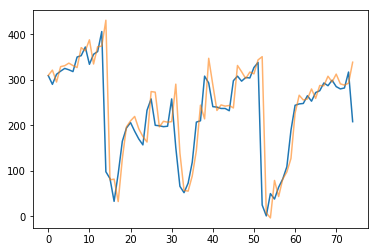

In [43]:
plt.plot(raw_values[train_size + 1:])
plt.plot(predictions, alpha = .6)


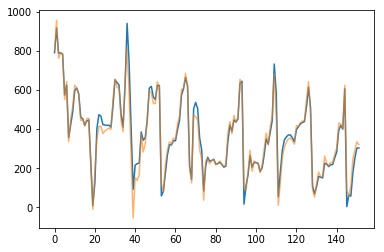

In [44]:
plt.plot(raw_values[:train_size ])
plt.plot(train_predictions, alpha = .6)


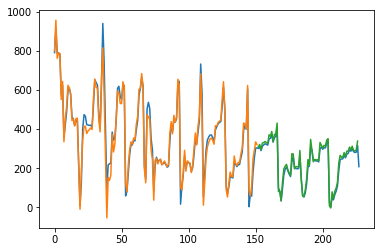

In [45]:
plt.plot(raw_values)
plt.plot(train_predictions)
plt.plot([None for x in train_predictions] + [x for x in predictions])

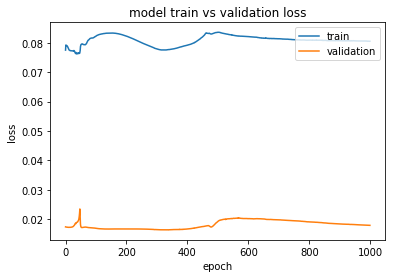

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')